# __EXP#4__

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, random_split, DataLoader
from sklearn.metrics import mean_squared_error
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation
import matplotlib.pyplot as plt

In [2]:
# predicted variable --- the Fame/Popularity of US presidents
# source: https://today.yougov.com/ratings/politics/popularity/US-presidents/all

In [3]:
# dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, xpath, ypath='../dataset/presidents_impression.csv', y_name='Popularity_rank'):
        # load the csv file as a dataframe
        dfx = pd.read_csv(xpath, index_col=0)
        dfy = pd.read_csv(ypath, index_col=0)
        # store the name of features
        self.features = dfx.columns
        # store the inputs and outputs
        self.X = dfx.values.astype('float32')
        self.y = dfy[y_name].values.astype('float32')
        # ensure target has the right shape
        self.y = self.y.reshape((len(self.y), 1))
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

In [4]:
# prepare the dataset
def prepare_data(path, p_test=0.2):
    # load the dataset
    dataset = CSVDataset(path)
    # calculate split
    train, test = dataset.get_splits(p_test)
    # prepare data loaders
    train_dl = DataLoader(train, shuffle=True)
    test_dl = DataLoader(test)
    return train_dl, test_dl

In [5]:
# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = nn.MarginRankingLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    # enumerate epochs
    for epoch in range(100):
        # enumerate mini batches
        for i, (inputs1, targets1) in enumerate(train_dl):
            for j, (inputs2, targets2) in enumerate(train_dl):
                # clear the gradients
                optimizer.zero_grad()
                # compute the model output
                yhat1 = model(inputs1) * 100
                yhat2 = model(inputs2) * 100
                # relative position
                if targets1 > targets2:
                    targets = torch.Tensor([1])
                elif targets1 < targets2:
                    targets = torch.Tensor([-1])
                else:
                    targets = torch.Tensor([0])
                # calculate loss
                loss = criterion(yhat1, yhat2, targets)
                # print(yhat1, yhat2, targets, loss)
                # credit assignment
                loss.backward()
                # update model weights
                optimizer.step()

In [6]:
# model definition
class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = nn.Linear(n_inputs, 7)
        nn.init.xavier_uniform_(self.hidden1.weight)
        self.act1 = nn.Sigmoid()
        # second hidden layer
        self.hidden2 = nn.Linear(7, 3)
        nn.init.xavier_uniform_(self.hidden2.weight)
        self.act2 = nn.Sigmoid()
        # third hidden layer and output
        self.hidden3 = nn.Linear(3, 1)
        nn.init.xavier_uniform_(self.hidden3.weight)
 
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        return X

In [7]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    return predictions, actuals

In [27]:
path = '../dataset/network_data/rank.csv'
train_dl, test_dl = prepare_data(path, p_test=0)
print(len(train_dl.dataset), len(test_dl.dataset), )

10 0


In [28]:
# initialize the model
model = MLP(len(train_dl.dataset.dataset.features))
# train the model
train_model(train_dl, model)

In [29]:
# evaluate model performace
predictions, actuals = evaluate_model(train_dl, model)

In [30]:
sorted_predictions = predictions.copy()
sorted_predictions.sort(axis=0)
predicted_rank = [np.where(predictions == num)[0][0] + 1 for num in sorted_predictions]

In [31]:
from itertools import combinations
correct = 0
total = 0
actual_pair = list(combinations(actuals.flatten(), 2))
predicted_pair = list(combinations(predicted_rank, 2))
for pair1 in actual_pair:
    for pair2 in predicted_pair:
        rank1 = 1 if pair1[0] > pair1[1] else 0
        rank2 = 1 if pair2[0] > pair2[1] else 0
        if rank1 == rank2:
            correct += 1
        total += 1
print(f'Correctly predicted pairwise position: {correct / total * 100}%')

Correctly predicted pairwise position: 60.0%


In [36]:
# attribute interpretation
ig = IntegratedGradients(model)
ig_attr_test = ig.attribute(torch.Tensor(train_dl.dataset.dataset.X), n_steps=50)
ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

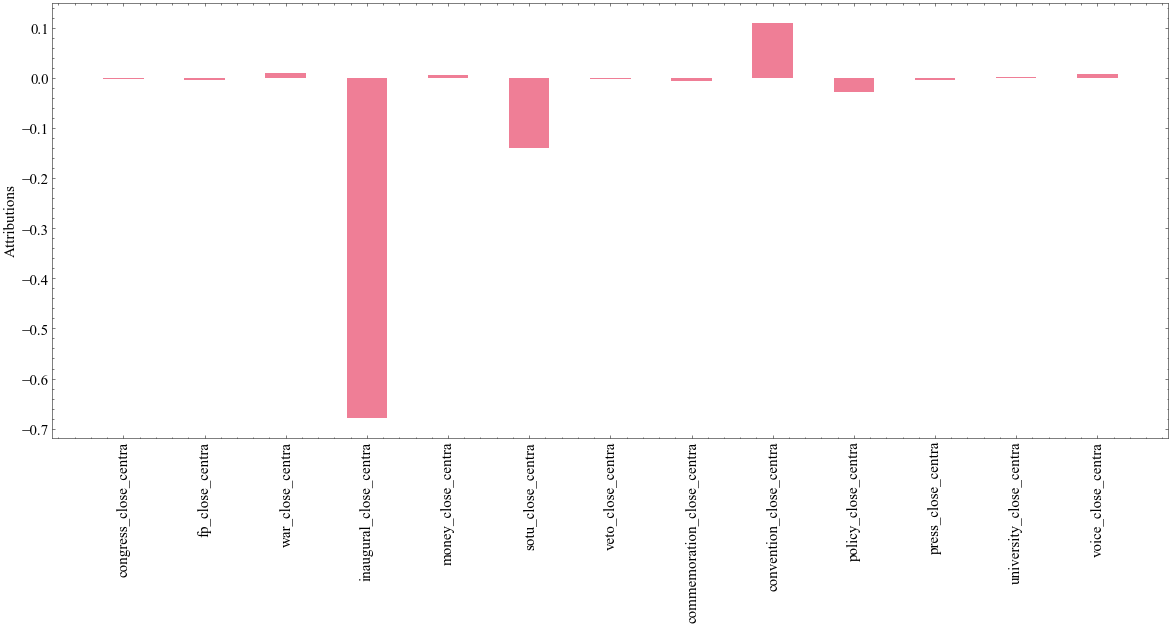

In [37]:
x_axis_data = np.arange(train_dl.dataset.dataset.X.shape[1])
x_axis_data_labels = list(map(lambda idx: CSVDataset(path).features[idx], x_axis_data))
plt.style.use(['nature', 'science', 'no-latex'])
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(20, 8))
ax = plt.subplot()
ax.set_ylabel('Attributions', fontsize=15)
ax.bar(x_axis_data, ig_attr_test_norm_sum, 0.5, align='center', alpha=0.8, color='#eb5e7c')
plt.xticks(x_axis_data, x_axis_data_labels, rotation = 90)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [15]:
dl = DeepLift(model)
dl_attr_test = dl.attribute(torch.Tensor(train_dl.dataset.dataset.X))
dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

/Users/shiyang/opt/anaconda3/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/Users/shiyang/opt/anaconda3/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [16]:
ig_nt = NoiseTunnel(ig)
ig_nt_attr_test = ig_nt.attribute(torch.Tensor(train_dl.dataset.dataset.X))
ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

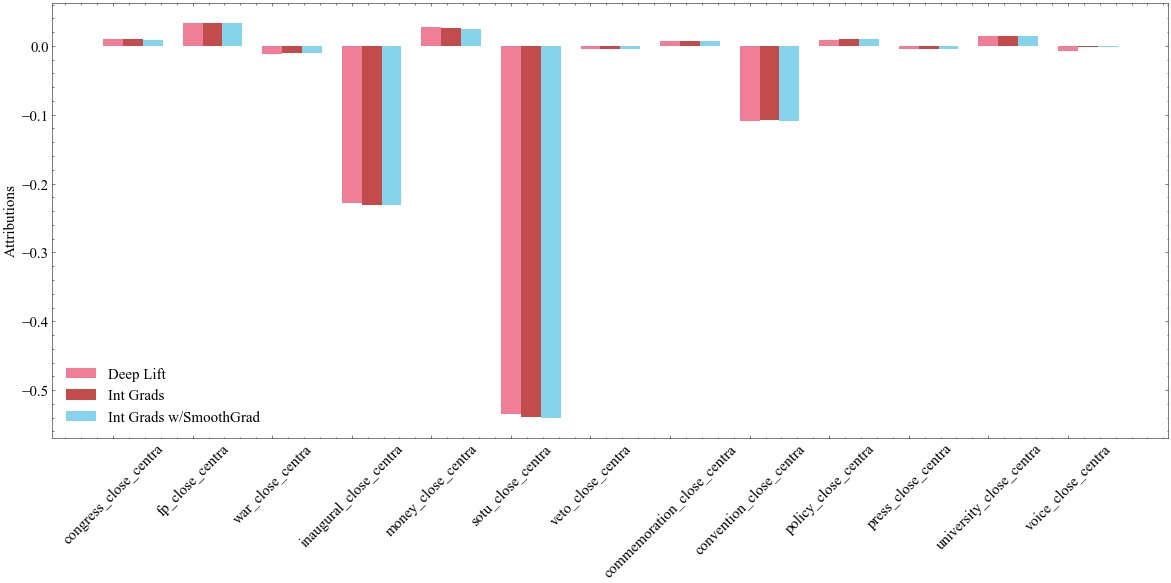

In [17]:
x_axis_data = np.arange(train_dl.dataset.dataset.X.shape[1])
x_axis_data_labels = list(map(lambda idx: CSVDataset(path).features[idx], x_axis_data))
plt.style.use(['nature', 'science', 'no-latex'])
plt.rcParams['font.family'] = 'Times New Roman'

legends = ['Deep Lift', 'Int Grads', 'Int Grads w/SmoothGrad']
plt.figure(figsize=(20, 8))
ax = plt.subplot()
ax.set_ylabel('Attributions', fontsize=15)
ax.bar(x_axis_data, dl_attr_test_norm_sum, 0.25, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data+0.25, ig_attr_test_norm_sum, 0.25, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data+0.5, ig_nt_attr_test_norm_sum, 0.25, align='center', alpha=0.6, color='#34b8e0')
plt.xticks(x_axis_data, x_axis_data_labels, rotation = 45)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legends, loc=0, fontsize=15)
plt.show()

In [38]:
# the original embedding?
# audio embeddings
path = '../dataset/audio_embedding.csv'
train_dl, test_dl = prepare_data(path, p_test=0)
print(len(train_dl.dataset), len(test_dl.dataset))
# initialize the model
model = MLP(len(train_dl.dataset.dataset.features))
# train the model
train_model(train_dl, model)
predictions, actuals = evaluate_model(train_dl, model)
sorted_predictions = predictions.copy()
sorted_predictions.sort(axis=0)
predicted_rank = [np.where(predictions == num)[0][0] + 1 for num in sorted_predictions]
correct = 0
total = 0
actual_pair = list(combinations(actuals.flatten(), 2))
predicted_pair = list(combinations(predicted_rank, 2))
for pair1 in actual_pair:
    for pair2 in predicted_pair:
        rank1 = 1 if pair1[0] > pair1[1] else 0
        rank2 = 1 if pair2[0] > pair2[1] else 0
        if rank1 == rank2:
            correct += 1
        total += 1
print(f'Correctly predicted pairwise position: {correct / total * 100}%')

10 0
Correctly predicted pairwise position: 57.1358024691358%


,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,President,Context
0,0.181331,-0.216684,-0.544488,-0.611155,0.670200,0.629231,0.829572,0.180684,-0.267612,-0.071309,...,-0.431345,1.446274,0.336069,-0.004548,-0.033097,-0.196469,-0.298374,0.180462,George Washington,Inaugural
1,0.074482,0.135035,-0.603059,-0.522697,0.543611,0.218145,1.020101,0.287235,-0.566654,0.032984,...,-0.432190,1.404181,0.237894,0.125117,0.001270,-0.188251,-0.279870,0.141353,George Washington,NaN
2,0.283171,-0.249959,-0.780900,-0.150407,0.470510,0.340004,0.911824,-0.080889,-0.863540,0.062720,...,-0.379478,1.577775,0.344026,-0.078891,-0.127875,-0.470203,-0.439464,0.299794,George Washington,Congress
3,0.344816,-0.389006,-0.705545,-0.159734,0.578245,0.353758,0.805898,-0.022889,-0.491712,-0.055933,...,-0.359677,1.432768,0.427462,-0.017370,-0.162265,-0.322714,-0.382797,0.248158,George Washington,Congress
4,0.331089,0.110525,-0.823918,-0.516313,0.540129,0.249331,0.792430,0.290042,-1.027863,0.433040,...,-0.673222,1.248854,0.269982,0.206357,-0.327722,-0.396733,-0.249741,0.154946,George Washington,Native
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,-1.019055,-0.397707,0.553363,0.468306,0.459096,0.217792,-2.021319,0.309904,0.600404,-0.336535,...,0.822564,-1.035741,0.088285,-0.870778,-0.443476,0.356030,0.764869,-0.179707,Donald Trump,Policy
988,-1.186838,-0.211526,0.728853,0.481660,-0.301145,0.183642,-1.734810,-0.080093,0.381865,-0.356193,...,0.910108,-0.265034,-0.477420,-0.367482,-0.362199,0.362186,0.500086,-0.423274,Donald Trump,SOTU
989,-0.991335,-0.209406,0.712428,0.720586,-0.581653,-0.380011,-1.855414,0.811226,0.179949,-0.771333,...,0.630451,-0.984968,-0.595049,-0.248280,-0.642676,0.321508,0.497539,-0.033003,Donald Trump,Policy
990,-1.317205,-0.274680,0.917583,0.355288,-0.178687,-0.010824,-1.795929,0.596932,0.765527,-0.581093,...,0.839046,-1.102021,-0.182430,-0.762123,-0.589451,0.200943,0.553819,-0.141830,Donald Trump,UN
